# Rolling State Memory (RSM) - Experimental Notebook

**Implementation using modular architecture**

This notebook demonstrates RSM training and evaluation using the clean architecture from `hybrid_transformer1.py`.

**Key improvements:**
- Modular imports from `hybrid_transformer1.py`
- Multiple dataset/tokenization options
- Clean experimental setup

## 1. Setup and Imports
Import all necessary components from our architecture module.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Optional, Tuple

# Import ALL RSM components from our clean architecture
from hybrid_transformer1 import (
    # NNDL Core Functions (Section 1)
    scaled_dot_attention,
    PositionalEncoding,
    MLP,
    CausalSelfAttention,

    # Memory Components (Section 2)
    CrossAttention,
    GatedSSM,
    GlobalSyncLayer,

    # Architecture (Section 3)
    HybridTransformerBlock,
    HybridTransformer,

    # Training Utilities (Section 4)
    train_rsm_epoch,

    # Generation Utilities (Section 5)
    generate_with_rsm,

    # Dataset Utilities (Section 6)
    ChunkedSequenceDataset,

    # Helper Functions (Section 7)
    create_rsm_model,
    save_checkpoint,
    load_checkpoint,
    count_parameters,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")
print("✓ Imported RSM architecture from hybrid_transformer1.py")

✓ hybrid_transformer1 module loaded.
Device: cuda
PyTorch version: 2.9.0+cu126
✓ Imported RSM architecture from hybrid_transformer1.py


In [2]:
# Clear GPU memory first
import torch
torch.cuda.empty_cache()
import gc
gc.collect()

30

## 2. Dataset & Tokenization Options

Choose your dataset and tokenization scheme based on your experiment goals.

### 📚 Dataset Options:

#### **Option 1: TinyStories** (Microsoft Research, 2023) ⭐
- **Paper:** "TinyStories: How Small Can Language Models Be and Still Speak Coherent English?"
- **Authors:** Eldan & Li (2023)
- **Size:** 2.1M synthetic stories generated by GPT-4
- **Length:** 500-2000 tokens per story
- **Use case:** Standard benchmark for small language models
- **Citation:** https://arxiv.org/abs/2305.07759

#### **Option 2: Tiny Shakespeare** (Karpathy's char-rnn) ⭐
- **Source:** Complete works of Shakespeare
- **Size:** ~1MB text, ~1M characters
- **Vocab:** ~65 unique characters
- **Use case:** Fast experiments, character-level modeling benchmark
- **Citation:** https://github.com/karpathy/char-rnn

#### **Option 3: WikiText-103** (Salesforce Research)
- **Paper:** "Pointer Sentinel Mixture Models"
- **Authors:** Merity et al. (2016)
- **Size:** 103M tokens from Wikipedia
- **Use case:** Long-form text, established benchmark
- **Citation:** https://arxiv.org/abs/1609.07843

#### **Option 4: Custom Text**
- Load your own `.txt` files
- Suitable for domain-specific applications

---

### 🔤 Tokenization Options:

#### **Method 1: BPE (Byte-Pair Encoding)** ⭐
- **Tokenizer:** GPT-2 (50K vocab)
- **Efficiency:** ~4 characters per token
- **Pros:** Semantic units, no OOV, pretrained
- **Cons:** Large vocabulary

#### **Method 2: SentencePiece** (Custom vocab size)
- **Vocab size:** Configurable (2K-8K typical)
- **Pros:** Trainable on your data, balanced
- **Cons:** Requires training step

#### **Method 3: Character-level**
- **Vocab size:** ~100 characters
- **Pros:** Simple, no OOV, works for any text
- **Cons:** Very long sequences, harder to learn patterns

In [3]:
# ============================================================================
# DATASET LOADING - Choose one option
# ============================================================================

# ----------------------------------------------------------------------------
# OPTION 1: TinyStories + GPT-2 BPE Tokenizer (COMMENTED OUT - using Shakespeare)
# ----------------------------------------------------------------------------
# Paper: "TinyStories: How Small Can Language Models Be and Still Speak Coherent English?"
# Eldan & Li, Microsoft Research, 2023
# https://arxiv.org/abs/2305.07759

# try:
#     from datasets import load_dataset
#     from transformers import GPT2Tokenizer
#
#     print("=" * 80)
#     print("LOADING TINYSTORIES DATASET")
#     print("=" * 80)
#
#     # Load dataset from HuggingFace
#     tinystories = load_dataset("roneneldan/TinyStories", split="train[:500]")
#     print(f"✓ Loaded {len(tinystories)} stories from TinyStories")
#
#     # Load GPT-2 tokenizer (50,257 vocab)
#     tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
#     tokenizer.pad_token = tokenizer.eos_token
#     vocab_size = len(tokenizer)
#
#     print(f"✓ GPT-2 BPE Tokenizer loaded")
#     print(f"  Vocabulary size: {vocab_size:,} tokens")
#     print(f"  Tokenization: Byte-Pair Encoding")
#
#     # Tokenize all stories
#     all_tokens = []
#     for story in tinystories:
#         tokens = tokenizer.encode(story['text'])
#         all_tokens.extend(tokens)
#
#     print(f"✓ Tokenized {len(all_tokens):,} tokens total")
#     print("=" * 80)
#
#     DATASET_NAME = "TinyStories"
#     TOKENIZATION = "BPE (GPT-2)"
#
# except ImportError:
#     print("⚠ HuggingFace libraries not installed")
#     print("Install with: pip install datasets transformers")
#     print("\nFalling back to character-level tokenization...")
#
#     # Fallback to character-level with sample text
#     sample_text = "Once upon a time, there was a little girl. " * 100
#
#     # Character-level tokenizer
#     chars = sorted(list(set(sample_text)))
#     char_to_idx = {ch: i for i, ch in enumerate(chars)}
#     idx_to_char = {i: ch for i, ch in enumerate(chars)}
#
#     all_tokens = [char_to_idx[ch] for ch in sample_text]
#     vocab_size = len(chars)
#
#     print(f"✓ Character-level tokenization")
#     print(f"  Vocabulary size: {vocab_size} characters")
#     print(f"  Total tokens: {len(all_tokens):,}")
#
#     DATASET_NAME = "Sample Text"
#     TOKENIZATION = "Character-level"
#
# print(f"\n📊 Dataset: {DATASET_NAME}")
# print(f"🔤 Tokenization: {TOKENIZATION}")
# print(f"📝 Vocabulary: {vocab_size:,} tokens")

## 2b. Alternative: Tiny Shakespeare Dataset

Uncomment this cell to use Tiny Shakespeare instead of TinyStories (faster, simpler, character-level).

In [4]:
# ============================================================================
# TINY SHAKESPEARE DATASET - WITH BPE TOKENIZATION
# ============================================================================
# Classic benchmark - Complete works of Shakespeare (~1MB, ~1M characters)
# Using BPE tokenization instead of character-level for better compression

import requests
from transformers import GPT2Tokenizer

print("=" * 80)
print("LOADING TINY SHAKESPEARE (BPE TOKENIZATION)")
print("=" * 80)

# Download Tiny Shakespeare
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
full_text = response.text

# Use only first 100K characters for faster training
#text = full_text[:100_000]
text = full_text
print(f"✓ Downloaded {len(full_text):,} characters (using first {len(text):,} for training)")

# BPE tokenization with GPT-2
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
vocab_size = len(tokenizer)

# Tokenize the text
all_tokens = tokenizer.encode(text)

DATASET_NAME = "Tiny Shakespeare (Full Dataset)"
TOKENIZATION = "BPE (GPT-2)"

print(f"✓ BPE tokenization with GPT-2")
print(f"  Vocabulary: {vocab_size:,} tokens")
print(f"  Total tokens: {len(all_tokens):,} (compressed from {len(text):,} chars)")
print(f"  Compression ratio: {len(text) / len(all_tokens):.2f}x")
print(f"  Expected batches per epoch: ~{len(all_tokens) // (256 * 128)}")
print("=" * 80)

print(f"\n📊 Dataset: {DATASET_NAME}")
print(f"🔤 Tokenization: {TOKENIZATION}")
print(f"📝 Vocabulary: {vocab_size:,} tokens")

# Preview
print(f"\n📖 Preview (first 50 tokens decoded):")
print(tokenizer.decode(all_tokens[:50]))

LOADING TINY SHAKESPEARE (BPE TOKENIZATION)
✓ Downloaded 1,115,394 characters (using first 1,115,394 for training)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (338025 > 1024). Running this sequence through the model will result in indexing errors


✓ BPE tokenization with GPT-2
  Vocabulary: 50,257 tokens
  Total tokens: 338,025 (compressed from 1,115,394 chars)
  Compression ratio: 3.30x
  Expected batches per epoch: ~10

📊 Dataset: Tiny Shakespeare (Full Dataset)
🔤 Tokenization: BPE (GPT-2)
📝 Vocabulary: 50,257 tokens

📖 Preview (first 50 tokens decoded):
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved.


## 3. Alternative Dataset Options (Commented)

Uncomment any of these to try different datasets:

In [5]:
# ----------------------------------------------------------------------------
# OPTION 2: WikiText-103 + GPT-2 Tokenizer
# ----------------------------------------------------------------------------
# Paper: "Pointer Sentinel Mixture Models"
# Merity et al., Salesforce Research, 2016
# https://arxiv.org/abs/1609.07843
#
# from datasets import load_dataset
# from transformers import GPT2Tokenizer
#
# wikitext = load_dataset("wikitext", "wikitext-103-v1", split="train")
# tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# tokenizer.pad_token = tokenizer.eos_token
#
# all_tokens = []
# for article in wikitext:
#     tokens = tokenizer.encode(article['text'])
#     all_tokens.extend(tokens)
#
# vocab_size = len(tokenizer)
# DATASET_NAME = "WikiText-103"
# TOKENIZATION = "BPE (GPT-2)"

# ----------------------------------------------------------------------------
# OPTION 4: Custom Text File + SentencePiece
# ----------------------------------------------------------------------------
# Train custom tokenizer on your data
# https://github.com/google/sentencepiece
#
# import sentencepiece as spm
#
# # Train SentencePiece model
# spm.SentencePieceTrainer.train(
#     input='your_data.txt',
#     model_prefix='custom_tokenizer',
#     vocab_size=4096,  # Adjustable
#     character_coverage=0.9995,
#     model_type='bpe'
# )
#
# # Load trained tokenizer
# tokenizer = spm.SentencePieceProcessor(model_file='custom_tokenizer.model')
#
# # Tokenize your text
# with open('your_data.txt', 'r') as f:
#     text = f.read()
# all_tokens = tokenizer.encode(text, out_type=int)
# vocab_size = tokenizer.vocab_size()
#
# DATASET_NAME = "Custom Text"
# TOKENIZATION = "SentencePiece BPE"

# ----------------------------------------------------------------------------
# OPTION 5: Character-level on Custom Text
# ----------------------------------------------------------------------------
# Simplest option - no dependencies
#
# with open('your_data.txt', 'r') as f:
#     text = f.read()
#
# chars = sorted(list(set(text)))
# char_to_idx = {ch: i for i, ch in enumerate(chars)}
# idx_to_char = {i: ch for i, ch in enumerate(chars)}
#
# all_tokens = [char_to_idx[ch] for ch in text]
# vocab_size = len(chars)
#
# DATASET_NAME = "Custom Text"
# TOKENIZATION = "Character-level"

print("Alternative dataset options available (see cell above)")

Alternative dataset options available (see cell above)


## 4. Model Configuration and Creation

Now we'll create the Hybrid Transformer model using the factory function from `hybrid_transformer1.py`.

In [6]:
# Model hyperparameters - CONSERVATIVE for T4 GPU
hidden_size = 256          # Smaller model
num_heads = 4              # Fewer heads
num_layers = 6             # Fewer layers
num_memory_slots = 32      # Fewer memory slots
chunk_size = 128           # SMALLER chunks (not 256!)
dropout = 0.1
use_global_sync = True


'''
# GPU-friendly parameters for T4 (15GB)
hidden_size = 384          # Reduced from 512
num_heads = 6              # Reduced from 8
num_layers = 8             # Reduced from 12
num_memory_slots = 48      # Reduced from 64
chunk_size = 256           # Keep this
dropout = 0.1
batch_size = 32
use_global_sync = True     # Whether to use global synchronization layer


# Model hyperparameters
hidden_size = 512         # Hidden dimension (d_model)
num_heads = 8              # Number of attention heads
num_layers = 12            # Number of transformer blocks (6, 8, 10)
num_memory_slots = 64      # Number of external memory slots
chunk_size = 256           # MUST MATCH training chunk_size! (was 512)
dropout = 0.1              # Dropout rate
use_global_sync = True     # Whether to use global synchronization layer

Increase to full 1M characters dataset
Train for 50+ epochs
Increase model size (hidden_size=512, num_layers=12)
'''
# Create model using factory function
model, global_sync, config = create_rsm_model(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    num_heads=num_heads,
    num_memory_slots=num_memory_slots,
    chunk_size=chunk_size,  # Now matches training chunk_size
    dropout=dropout,
    use_global_sync=use_global_sync,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Model is already created with summary printed by create_rsm_model()
# Additional info:
print(f"\n✓ Model ready for training")
print(f"✓ Global sync layer: {'Enabled' if use_global_sync else 'Disabled'}")
print(f"⚠️  Model chunk_size ({chunk_size}) now matches training chunk_size")

RSM MODEL CREATED
Vocabulary: 50,257 tokens
Hidden size: 256
Layers: 6
Attention heads: 4
Memory slots: 32
Chunk size: 128
Global sync: Yes

Parameters:
  Main model: 20,367,104
  Global sync: 525,824
  Total: 20,892,928
  Memory (float32): 79.7 MB

✓ Model ready for training
✓ Global sync layer: Enabled
⚠️  Model chunk_size (128) now matches training chunk_size


## 5. Prepare Training Data

Create the dataset and dataloader using `ChunkedSequenceDataset` from `hybrid_transformer1.py`.

In [7]:

# Training parameters - SMALL BATCH
chunk_size = 128           # Match model chunk_size
batch_size = 8             # VERY SMALL - start here!
num_epochs = 50
learning_rate = 3e-4


# Create dataset
train_dataset = ChunkedSequenceDataset(
    tokens=all_tokens,
    chunk_size=chunk_size  # Fixed: was seq_length, should be chunk_size
)

# Create dataloader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0  # Set to 0 for simpler debugging
)

print(f"Training dataset prepared:")
print(f"  Total tokens: {len(all_tokens):,}")
print(f"  Chunk size: {chunk_size} (GPU optimized)")
print(f"  Batch size: {batch_size} (GPU optimized)")
print(f"  Number of batches: {len(train_loader):,}")
print(f"  Number of epochs: {num_epochs}")
print(f"  Learning rate: {learning_rate}")
print(f"\n  GPU Training: T$")
print(f"\n⏱️  Expected time per epoch: ~30-60 seconds on GPU")

Training dataset prepared:
  Total tokens: 338,025
  Chunk size: 128 (GPU optimized)
  Batch size: 8 (GPU optimized)
  Number of batches: 660
  Number of epochs: 50
  Learning rate: 0.0003

  GPU Training: T$

⏱️  Expected time per epoch: ~30-60 seconds on GPU


## 6. Training Loop

Train the model using `train_rsm_epoch()` from `hybrid_transformer1.py`.

In [8]:
# Setup optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Training history
history = {
    'train_loss': [],
    'train_acc': []
}

# Training loop
print("Starting training...")
print("=" * 60)

for epoch in range(num_epochs):
    # train_rsm_epoch returns a dict with 'loss', 'accuracy', 'num_chunks'
    metrics = train_rsm_epoch(
        model=model,
        global_sync=global_sync,
        data_iterator=train_loader,
        optimizer=optimizer,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        batch_size=batch_size  # Explicitly pass batch_size
    )

    # Extract metrics
    loss = metrics['loss']
    acc = metrics['accuracy'] * 100  # Convert to percentage

    # Store history
    history['train_loss'].append(loss)
    history['train_acc'].append(acc)

    # Print progress (single line per epoch)
    print(f"Epoch {epoch+1:2d}/{num_epochs} | Loss: {loss:.4f} | Accuracy: {acc:.2f}%")

    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        save_checkpoint(
            filepath=f'checkpoint_epoch_{epoch+1}.pt',
            model=model,
            global_sync=global_sync,
            optimizer=optimizer,
            config=config,
            history=history
        )
        print(f"  → Checkpoint saved: checkpoint_epoch_{epoch+1}.pt")

print("=" * 60)
print("Training complete!")
print(f"Final Loss: {history['train_loss'][-1]:.4f}")
print(f"Final Accuracy: {history['train_acc'][-1]:.2f}%")

Starting training...
Epoch  1/50 | Loss: 6.3980 | Accuracy: 13.20%
Epoch  2/50 | Loss: 5.5898 | Accuracy: 17.32%
Epoch  3/50 | Loss: 5.1841 | Accuracy: 19.74%
Epoch  4/50 | Loss: 4.9559 | Accuracy: 21.26%
Epoch  5/50 | Loss: 4.7676 | Accuracy: 22.61%
Epoch  6/50 | Loss: 4.5867 | Accuracy: 24.12%
Epoch  7/50 | Loss: 4.4274 | Accuracy: 25.56%
Epoch  8/50 | Loss: 4.2885 | Accuracy: 26.71%
Epoch  9/50 | Loss: 4.1612 | Accuracy: 27.74%
Epoch 10/50 | Loss: 4.0456 | Accuracy: 28.63%
✓ Checkpoint saved to checkpoint_epoch_10.pt
  → Checkpoint saved: checkpoint_epoch_10.pt
Epoch 11/50 | Loss: 3.9340 | Accuracy: 29.40%
Epoch 12/50 | Loss: 3.8368 | Accuracy: 30.23%
Epoch 13/50 | Loss: 3.7366 | Accuracy: 31.06%
Epoch 14/50 | Loss: 3.6396 | Accuracy: 32.05%
Epoch 15/50 | Loss: 3.5385 | Accuracy: 33.14%
Epoch 16/50 | Loss: 3.4417 | Accuracy: 34.17%
Epoch 17/50 | Loss: 3.3450 | Accuracy: 35.27%
Epoch 18/50 | Loss: 3.2534 | Accuracy: 36.31%
Epoch 19/50 | Loss: 3.1605 | Accuracy: 37.40%
Epoch 20/50 | L

## 7. Visualize Training Results

Plot the loss and accuracy curves.

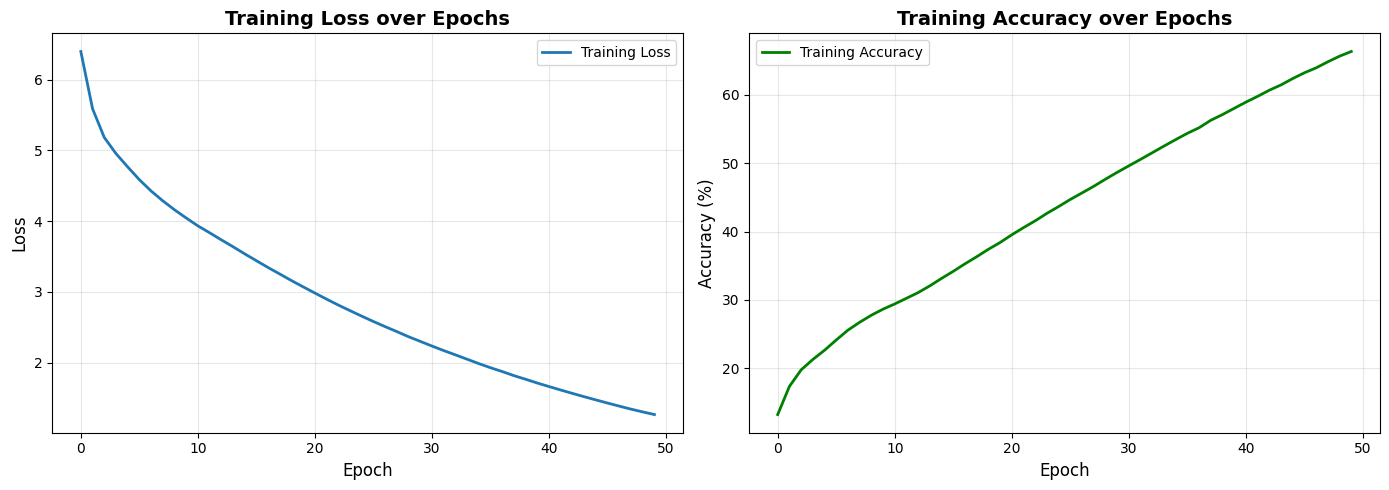


Training Statistics:
  Best Loss: 1.2680 (Epoch 50)
  Best Accuracy: 66.36% (Epoch 50)


In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
ax1.plot(history['train_loss'], label='Training Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training Loss over Epochs', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot accuracy
ax2.plot(history['train_acc'], label='Training Accuracy', color='green', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training Accuracy over Epochs', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nTraining Statistics:")
print(f"  Best Loss: {min(history['train_loss']):.4f} (Epoch {history['train_loss'].index(min(history['train_loss']))+1})")
print(f"  Best Accuracy: {max(history['train_acc']):.2f}% (Epoch {history['train_acc'].index(max(history['train_acc']))+1})")

## 8. Text Generation

Generate text samples using `generate_with_rsm()` from `hybrid_transformer1.py`.

In [14]:
# Set model to evaluation mode
model.eval()

# Generate text samples with different prompts (Shakespeare-themed)
prompts = [
    "Enter HAMLET",
    "The castle gates",
    "LADY MACBETH speaks"
]

print("Generated Text Samples:")
print("=" * 60)

for i, prompt in enumerate(prompts, 1):
    # Encode prompt
    if TOKENIZATION == "Character-level":
        prompt_tokens = [char_to_idx.get(ch, 0) for ch in prompt]
    else:
        prompt_tokens = tokenizer.encode(prompt)

    # Generate
    generated_tokens = generate_with_rsm(
        model=model,
        prompt_tokens=prompt_tokens,
        max_new_tokens=100,
        temperature=0.8,
        top_k=50,
        top_p=0.92,
        device='cuda' if torch.cuda.is_available() else 'cpu'
    )

    # Decode
    if TOKENIZATION == "Character-level":
        generated_text = ''.join([idx_to_char.get(idx, '?') for idx in generated_tokens])
    else:
        generated_text = tokenizer.decode(generated_tokens)

    print(f"\nSample {i}:")
    print(f"Prompt: \"{prompt}\"")
    print(f"Generated:\n{generated_text}")
    print("-" * 60)

print("\nGeneration complete!")

Generated Text Samples:

Sample 1:
Prompt: "Enter HAMLET"
Generated:
Enter HAMLET
Are but seized and wantough and ay and ay
But deans'd sedals and lough'd
As words and all and words and freely
But see their breath and they lie of
This day and ambitious as friend as they had they
For slaves of words or they had had they think'd than
As they pass'd them?
But why nature of the Voly mind
Should power to kings or kings? or why we
But that last as news as being brought
------------------------------------------------------------

Sample 2:
Prompt: "The castle gates"
Generated:
The castle gates
Are but unsars for Mowbray,
As with all earth and allay,
As doth rebate and
In name and all of grieved dewish'd and mild de
But yet had foul Grow'd and mildum
As best'd by mild beggar Hereford's womb,
Entled, and stark mad of foul bay,
In what name of temper'd and thirsty one gorn,
As thou wert borne against the grave of
------------------------------------------------------------

Sample 3:
Prompt: "L